In [95]:
from pymongo import MongoClient
import pandas as pd
from bson.objectid import ObjectId
import datetime
import time
import matplotlib.pylab as plt
import matplotlib as mpl
import numpy as np
import talib
import seaborn as sns

connectionLocal = MongoClient('52.90.110.245', 27017)
db = connectionLocal.ETF_db
TradesData = db.TradesData
arbitragecollection = db.ArbitrageCollection

# Convert UTC to EST accounting for day light saving 
import pytz
est = pytz.timezone('US/Eastern')
utc = pytz.utc
fmt = '%Y-%m-%d %H:%M:%S %Z%z'

# Jupyter Notebook to display all the columns in a df
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199

## Load ETF Prices

In [69]:
def LoadETFPrices(etfname,dateOfAnalyis,year):
    starthour=dateOfAnalysis.strftime('%Y-%m-%d')+' 08:59:00'
    endhour=dateOfAnalysis.strftime('%Y-%m-%d')+' 16:01:00'
    def getHumanTime(ts=None, divideby=1000000000):
        s, ms = divmod(ts, divideby)
        return datetime.datetime(*time.gmtime(s)[:6])

    etfpricesData={}
    prices = TradesData.find_one({"symbol":etfname, 'dateForData':dateOfAnalyis})
    pricedf = pd.DataFrame(prices['data'])
    pricedf['t'] = pricedf['t'].apply(lambda x: getHumanTime(ts=x, divideby=1000))
    pricedf = pricedf.rename(columns={'t':'Time','o':'Open','h':'High','c':'Close','l':'Low','v':'Volume'})
    pricedf = pricedf[['Time','Volume','Open','Close','High','Low']]

    if dateOfAnalyis > datetime.datetime(year-1,9,1) and dateOfAnalyis < datetime.datetime(year,3,8):
        pricedf['Time']=pricedf['Time'] - datetime.timedelta(hours=5)
    else:
        pricedf['Time']=pricedf['Time'] - datetime.timedelta(hours=4)
    return pricedf[(pricedf['Time']>starthour) & (pricedf['Time']<endhour)]

def loadETFArbitrageData(etfdata,dateOfAnalyis,year):
    starthour=dateOfAnalysis.strftime('%Y-%m-%d')+' 08:59:00'
    endhour=dateOfAnalysis.strftime('%Y-%m-%d')+' 16:01:00'

    etfdata = pd.DataFrame(etfdata)
    # Convert UTC time to E"ST time, Check if winter time - 5, Summer time - 4 
    if dateOfAnalyis > datetime.datetime(year-1,9,1) and dateOfAnalyis < datetime.datetime(year,3,8):
        etfdata['Time']=etfdata['Time'] - datetime.timedelta(hours=5)
    else:
        etfdata['Time']=etfdata['Time'] - datetime.timedelta(hours=4)
    return etfdata[(etfdata['Time']>starthour) & (etfdata['Time']<endhour)]

def analysePerformance(df=None, BuySellIndex=None):
    singalDf={}
    for dateindex in BuySellIndex.index:
        idx = df.index.get_loc(dateindex)
        res=df.iloc[(idx+1) : (idx + 6)]['ETF Change Price %']
        temp = list(res.values)
        if len(res.values)<5:
            [temp.append(np.nan) for i in range(5-len(res.values))]    
        singalDf[dateindex] = temp

    singalDf=pd.DataFrame(singalDf).T
    singalDf.columns=['T+1','T+2','T+3','T+4','T+5']
    singalDf.loc['Total Return',:]=singalDf.sum(axis=0)
    return singalDf

### Build Signals

In [145]:
def BuildSignals(df):
    tp=10
    # SMA
    df['Momentum Signal']=talib.SMA(df['ETF Price'],timeperiod=tp)
    description='SMA'
    df['Momentum Indicator'] = 0
    df.loc[(abs(df['ETF Price']) > df['Momentum Signal']), 'Momentum Indicator'] = 111
    df.loc[(abs(df['ETF Price']) < df['Momentum Signal']), 'Momentum Indicator'] = -111

    # CMO - Chande Momentum Oscillator
    df['CMO Signal']=talib.CMO(df['Close'],timeperiod=tp)
    description='CMO'
    df['CMO Indicator'] = 0
    df.loc[df['CMO Signal']>=50, 'CMO Indicator'] = 111
    df.loc[df['CMO Signal']<=-50, 'CMO Indicator'] = -111
    
    # ADX
    df['ADX Signal']=talib.ADX(df['High'],df['Low'],df['Close'],timeperiod=tp)
    description='ADX'
    df['ADX Trend'] = 0
    df.loc[df['ADX Signal']>25, 'ADX Trend'] = 'Strong Trend'
    df.loc[df['ADX Signal']<20, 'ADX Trend'] = 'Weak Trend'

    # Plus Di
    df['PusDISignal']=talib.PLUS_DI(df['High'],df['Low'],df['Close'],timeperiod=tp)
    df['PlusDITrend'] = 0
    df.loc[df['PusDISignal']>50, 'PlusDITrend'] = 'Strong Buy'
    df.loc[df['PusDISignal']>75, 'PlusDITrend'] = 'Extreme Strong Buy'

    # Minus DI
    df['MinusDISignal']=talib.MINUS_DI(df['High'],df['Low'],df['Close'],timeperiod=tp)
    df['MinusDITrend'] = 0
    df.loc[df['MinusDISignal']>50, 'MinusDITrend'] = 'Strong Sell'
    df.loc[df['MinusDISignal']>75, 'MinusDITrend'] = 'Extreme Strong Sell'
    

    # STOCHRSI
    fastk, fastd=talib.STOCHRSI(df['ETF Price'], timeperiod=tp, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['FastStochastic']=fastk
    df['Stochastic Indicator']=np.where(fastk>80, 111, 0)+np.where(fastk<20, -111, 0)
    
    return df

## Strategy Notes - 4 Types of signals

#### Buy = Green = Upward Arrow = etfOverSold = -111
#### Sell = Blue = Downward Arrow = etfoverBought = 111


#### 4 Types of Signals

1) Buy Positive = When 


2) Buy Negative


3) Sell Positive


4) Sell Negative


Combine trend with Buy and sell. 

In [140]:
etfname='FTEC'
s=arbitragecollection.find({'ETFName':etfname}).sort([('dateOfAnalysis', 1)])

In [141]:
for i in s:
    print(i['dateOfAnalysis'])

2020-03-18 00:00:00
2020-03-19 00:00:00
2020-03-20 00:00:00
2020-03-23 00:00:00
2020-03-24 00:00:00
2020-03-25 00:00:00
2020-03-26 00:00:00
2020-03-27 00:00:00
2020-03-30 00:00:00
2020-03-31 00:00:00
2020-04-01 00:00:00
2020-04-02 00:00:00
2020-04-03 00:00:00
2020-04-06 00:00:00
2020-04-07 00:00:00
2020-04-08 00:00:00
2020-04-09 00:00:00
2020-04-13 00:00:00
2020-04-14 00:00:00
2020-04-15 00:00:00


ETF Name =FTEC
Date =2020-03-18 00:00:00
Sell Positions Probability
T+1    0.818182
T+2    0.636364
T+3    0.363636
T+4    0.545455
T+5    0.636364
dtype: float64
Sell Positions N+1 Days


,ETF Trading Spread in $,Arbitrage in $,ADX Trend,Momentum Indicator,CMO Indicator,Stochastic Indicator,PlusDITrend,MinusDITrend,PusDISignal,MinusDISignal,T+1,T+2,T+3,T+4,T+5
2020-03-18 10:31:00,0.066442,0.117694,Weak Trend,111.0,0.0,111.0,0,0,36.036610,21.330717,-0.169609,-0.344620,0.224777,-0.138014,0.000000
2020-03-18 10:52:00,0.060807,0.138408,0,-111.0,0.0,-111.0,0,0,20.558588,42.259177,-0.355718,-0.191554,0.000000,0.000000,-0.012649
2020-03-18 11:09:00,0.053296,0.098946,Strong Trend,-111.0,0.0,0.0,0,Strong Sell,12.037533,56.667469,-0.254542,0.006600,-0.020678,-0.016722,-0.057216
2020-03-18 11:11:00,0.056737,0.076766,Strong Trend,-111.0,-111.0,-111.0,0,Strong Sell,12.936513,59.291497,-0.020678,-0.016722,-0.057216,-0.057249,0.066094
2020-03-18 12:26:00,0.063825,0.098966,0,111.0,0.0,111.0,0,0,23.735264,30.006940,-0.160749,0.066503,0.003498,0.122420,-0.253275
2020-03-18 12:36:00,0.068423,0.097247,0,-111.0,0.0,0.0,0,0,19.195001,44.314807,-0.110093,-0.039677,0.128429,0.000000,-0.172311
2020-03-18 13:46:00,0.088375,0.146646,0,-111.0,0.0,-111.0,0,0,29.609119,39.049357,0.030221,-0.021166,0.316656,-0.045094,-0.261662
2020-03-18 14:18:00,0.055784,0.180287,0,111.0,0.0,111.0,0,0,24.896681,25.308801,-0.273473,-0.155941,-0.145931,-0.036674,0.238466
2020-03-18 15:24:00,0.059301,0.119838,Weak Trend,-111.0,0.0,0.0,0,0,25.238484,29.286988,-0.230342,0.244455,-0.144509,-0.081675,-0.008781
2020-03-18 15:51:00,0.075464,0.101724,Strong Trend,111.0,0.0,111.0,0,0,39.266933,11.239934,0.089190,0.440474,0.368809,0.433130,0.314293


******************
Buy Positions Probability
T+1    0.636364
T+2    0.272727
T+3    0.090909
T+4    0.545455
T+5    0.181818
dtype: float64
Buy Positions N+1 Days


,ETF Trading Spread in $,Arbitrage in $,ADX Trend,Momentum Indicator,CMO Indicator,Stochastic Indicator,PlusDITrend,MinusDITrend,PusDISignal,MinusDISignal,T+1,T+2,T+3,T+4,T+5
2020-03-18 10:30:00,0.081376,-0.101460,Weak Trend,111.0,0.0,111.0,0,0,30.426272,25.074768,0.316825,-0.169609,-0.344620,0.224777,-0.138014
2020-03-18 10:53:00,0.057126,-0.178664,Strong Trend,-111.0,0.0,-111.0,0,Strong Sell,17.781923,50.057713,-0.191554,0.000000,0.000000,-0.012649,0.000000
2020-03-18 11:05:00,0.060362,-0.108139,Strong Trend,-111.0,-111.0,-111.0,0,Strong Sell,14.603123,53.968205,-0.149116,-0.096348,-0.178152,0.064291,-0.254542
2020-03-18 11:10:00,0.060086,-0.120877,Strong Trend,-111.0,-111.0,-111.0,0,Strong Sell,10.341845,62.771580,0.006600,-0.020678,-0.016722,-0.057216,-0.057249
2020-03-18 12:43:00,0.066884,-0.088131,Strong Trend,-111.0,0.0,-111.0,0,0,12.942567,45.150440,0.325446,0.089238,-0.167062,-0.281839,-0.026497
2020-03-18 12:53:00,0.062895,-0.113939,Strong Trend,-111.0,0.0,-111.0,0,Strong Sell,16.766213,51.521445,-0.142083,-0.142285,-0.204827,0.019722,0.285773
2020-03-18 14:02:00,0.064630,-0.086421,0,-111.0,0.0,-111.0,0,0,22.210628,45.541760,0.033393,-0.257322,-0.033833,0.391261,0.110042
2020-03-18 14:41:00,0.075337,-0.118509,Strong Trend,111.0,0.0,-111.0,0,0,44.694260,24.590993,0.003635,-0.158119,0.086466,0.328832,-0.123814
2020-03-18 15:25:00,0.070289,-0.106034,Weak Trend,-111.0,0.0,-111.0,0,0,23.043102,35.437994,0.244455,-0.144509,-0.081675,-0.008781,-0.190205
2020-03-18 15:57:00,0.118220,-0.166983,Strong Trend,111.0,0.0,-111.0,0,0,36.301945,29.013649,-0.173073,1.053448,0.000000,NaN,NaN


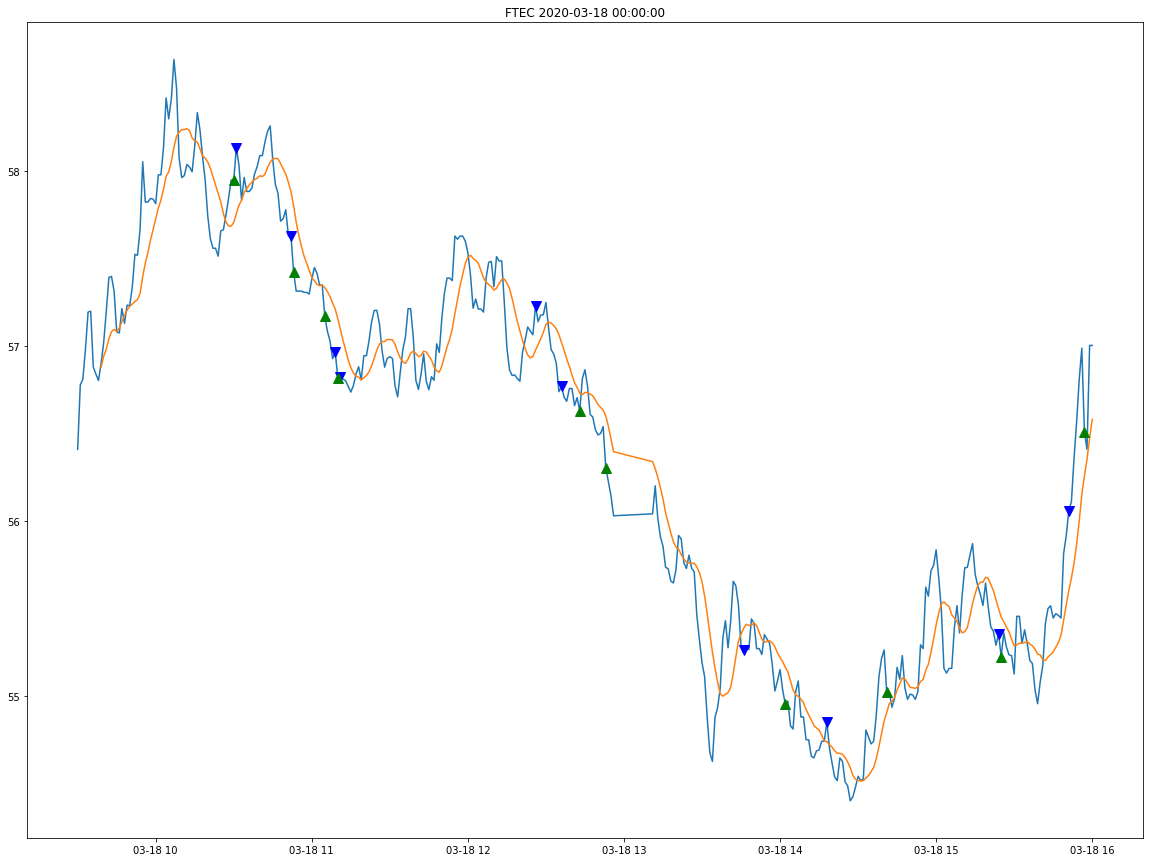

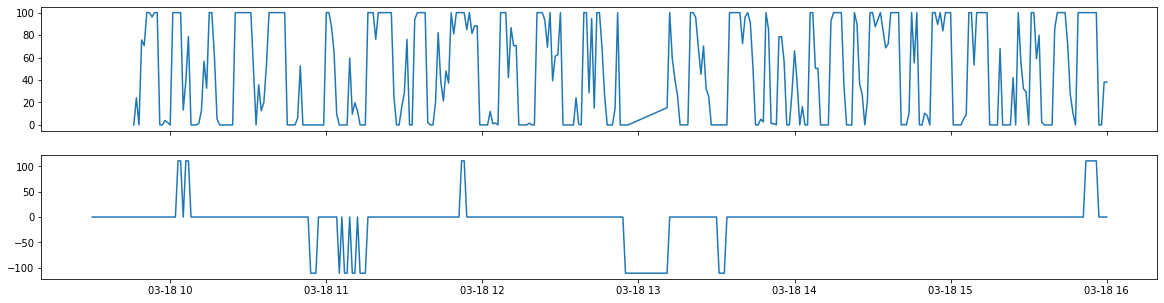

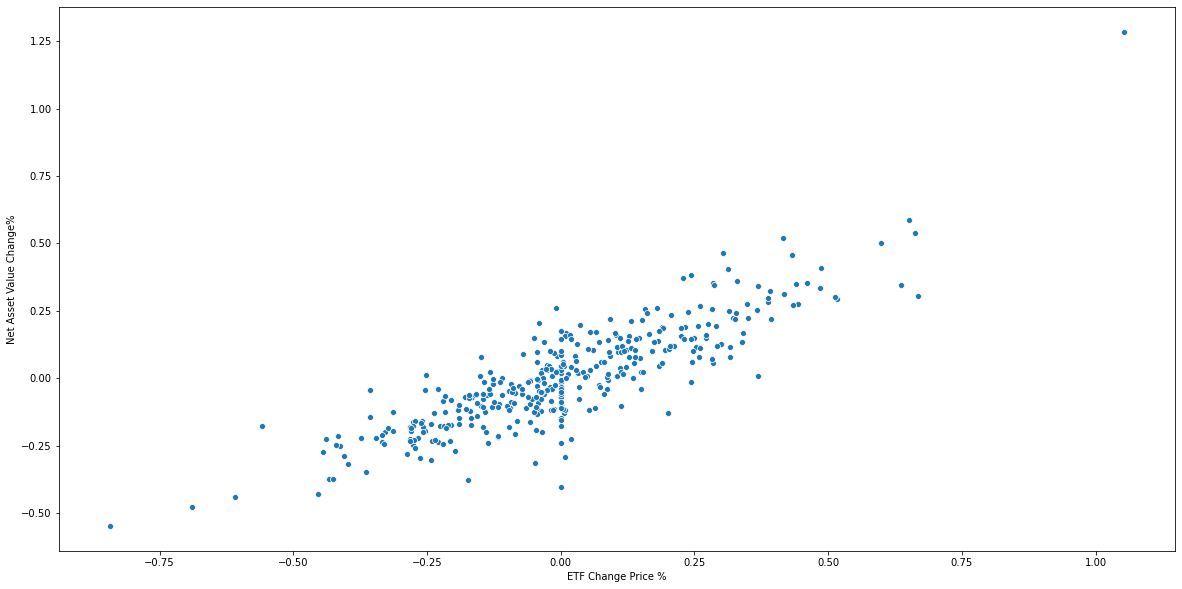

In [146]:
etfname='FTEC'
s=arbitragecollection.find({'ETFName':etfname}).sort([('dateOfAnalysis', 1)])
for i in s:
    dateOfAnalysis=(i['dateOfAnalysis'])
    year=dateOfAnalysis.year
    # Load Prices Data
    pricedf=LoadETFPrices(etfname,dateOfAnalysis,year)
    # Load Arbitrage Data
    etfdata=loadETFArbitrageData(i['data'],dateOfAnalysis,year)
    
    df=pd.merge(etfdata,pricedf,on='Time',how='left')
    df=df.ffill(axis=0)
    
    magnitute = 0.02
    df['Magnitude of Arbitrage']=abs(df['ETF Trading Spread in $']-abs(df['Arbitrage in $']))
    df['Flag'] = 0
    a = (abs(df['Arbitrage in $']) > df['ETF Trading Spread in $'])
    b = df['ETF Trading Spread in $'] != 0
    c = df['Magnitude of Arbitrage'] > magnitute
    df.loc[a & b & c, 'Flag'] = 111
    df['Flag'] = df['Flag'] * np.sign(df['Arbitrage in $'])
    df=df.set_index('Time')
    
    # Build Signals
    df=BuildSignals(df)
    
    print("ETF Name ="+ etfname)
    
    plt.figure(figsize=(20,15))
    plt.plot(df.index,df['ETF Price'], label='ETF Price')
    plt.plot(df.index, df['Momentum Signal'], label='Momentum Signal')
    
    
    columnsneeded=['ETF Trading Spread in $','Arbitrage in $','ADX Trend','Momentum Indicator','CMO Indicator','Stochastic Indicator','PlusDITrend','MinusDITrend','PusDISignal','MinusDISignal']
    etfOverBought = df.loc[df['Flag']== 111.0]
    if etfOverBought.shape[0]!=0:
        sellPositions = analysePerformance(df=df, BuySellIndex=etfOverBought)
        print("Date ="+str(dateOfAnalysis))
        print("Sell Positions Probability")
        print(sellPositions[sellPositions<0].count()/sellPositions.shape[0])
        
        tempdf=df.loc[etfOverBought.index]
        tempdf=tempdf[columnsneeded]
        sellPositions=pd.merge(tempdf,sellPositions,how='outer',left_index=True,right_index=True)
        
        print("Sell Positions N+1 Days")
        display(sellPositions)
        plt.plot(etfOverBought.index, df.loc[etfOverBought.index]['ETF Price'], 'v', markersize=10, color='b')
        
    etfOverSold = df.loc[df['Flag']== -111.0]
    if etfOverSold.shape[0]!=0:
        buyPositions  = analysePerformance(df=df, BuySellIndex=etfOverSold)
        print("******************")
        print("Buy Positions Probability")
        print(buyPositions[buyPositions>0].count()/buyPositions.shape[0])
        print("Buy Positions N+1 Days")
        
        tempdf=df.loc[etfOverSold.index]
        tempdf=tempdf[columnsneeded]
        buyPositions=pd.merge(tempdf,buyPositions,how='outer',left_index=True,right_index=True)
        
        display(buyPositions)
        plt.plot(etfOverSold.index, df.loc[etfOverSold.index]['ETF Price'], '^', markersize=10, color='g')
    plt.title(etfname+' '+str(dateOfAnalysis))
    plt.show()

    fig, ax = plt.subplots(nrows=2,sharex=True,figsize=(20, 5))
    ax[0].plot(df.index,df['FastStochastic'])
    ax[1].plot(df.index,df['CMO Indicator'])
    plt.show()


    a4_dims = (20,10)
    fig, ax = plt.subplots(figsize=a4_dims)
    sns.scatterplot(x=df['ETF Change Price %'], y=df['Net Asset Value Change%'])
    plt.show()
    

    if dateOfAnalysis.strftime('%Y-%m-%d')=='2020-03-18':
        break



In [82]:
fastk, fastd=talib.STOCHRSI(df['ETF Price'], timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
df['Stochastic Sisgna']=np.where(fastk>80, 111, 0)+np.where(fastk<20, -111, 0)

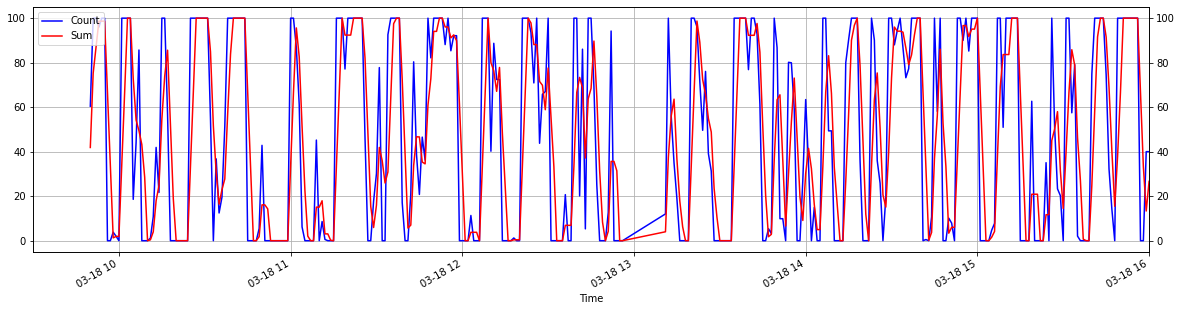

In [39]:
plt.figure(figsize=(20,5))
plt.xlabel('Number of requests every 10 minutes')

ax1 = fastk.plot(color='blue', grid=True, label='Count')
ax2 = fastd.plot(color='red', grid=True, secondary_y=True, label='Sum')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

In [129]:
talib.PLUS_DI(df['High'],df['Low'],df['Close'],timeperiod=5)

Time
2020-03-18 09:30:00   NaN       
2020-03-18 09:31:00   NaN       
2020-03-18 09:32:00   NaN       
2020-03-18 09:33:00   NaN       
2020-03-18 09:34:00   NaN       
2020-03-18 09:35:00    35.327314
2020-03-18 09:36:00    27.197437
2020-03-18 09:37:00    21.407942
2020-03-18 09:38:00    17.834321
2020-03-18 09:39:00    20.797278
2020-03-18 09:40:00    29.239678
2020-03-18 09:41:00    44.974277
2020-03-18 09:42:00    53.360927
2020-03-18 09:43:00    47.944159
2020-03-18 09:44:00    42.177723
2020-03-18 09:45:00    28.518991
2020-03-18 09:46:00    20.661670
2020-03-18 09:47:00    20.054791
2020-03-18 09:48:00    17.035658
2020-03-18 09:49:00    30.286163
2020-03-18 09:50:00    24.528765
2020-03-18 09:51:00    25.461289
2020-03-18 09:52:00    39.850597
2020-03-18 09:53:00    34.457252
2020-03-18 09:54:00    46.305134
2020-03-18 09:55:00    60.055850
2020-03-18 09:56:00    46.316606
2020-03-18 09:57:00    36.887365
2020-03-18 09:58:00    30.808594
2020-03-18 09:59:00    29.216414
2020-